In [9]:
%run ./data/data.ipynb

Pulling data from sources.json:
(Source: CBS)  deceased @ https://opendata.cbs.nl/statline/portal.html?_catalog=CBS&_la=nl&tableId=70895ned&_theme=76
(Source: CBS)  population @ https://opendata.cbs.nl/statline/portal.html?_catalog=CBS&_la=nl&tableId=37230ned&_theme=76
(Source: RIVM)  counts_per_municipality @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427
(Source: RIVM)  prevalence @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/097155aa-75eb-4caa-8ed3-4c6edb80467e
(Source: RIVM)  r @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/ed0699d1-c9d5-4436-8517-27eb993eab6e
(Source: RIVM)  homes_for_elderly @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/0179dd26-7bf6-4021-857f-8623aaf8e73a
(Source: RIVM)  homes_for_disabled @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/aa28b74d-7150-47bc-a7cb-98876e93381b
(Source: RIVM)  seventy_plus_living_at_home @ https://da

# Check RIVM modellen
https://www.rivm.nl/coronavirus-covid-19/hoe-berekeningen-bijdragen-aan-bestrijding-van-virus/rekenmodellen

https://github.com/lo-hfk/epyestim

## Tried covid-seird = False
https://github.com/pblins/covid_seird

Not able to load custom data

## trying SEIR
https://pypi.org/project/SEIR/

In [2]:
import os
import sys
import click
import numpy as np
import seaborn as sns
import datetime

from SEIR.seir import SEIR
from SEIR.visualization import visualize_seir_computation

from matplotlib import rcParams
rcParams['figure.figsize'] = 20,10

In [3]:
visualize_compartments = False
output_file_format = 'csv'
#output_file_format = 'json'
output_file = './data/csvs/seir.'+output_file_format

In [4]:
# Define model
def run_model(action=None):
    model = SEIR(
        incubation_period=incubation_period,
        infectious_period=infectious_period,
        initial_R0=initial_R0,
        hospitalization_probability=hospitalization_probability,
        hospitalization_duration=hospitalization_duration,
        hospitalization_lag_from_onset=hospitalization_lag_from_onset,
        icu_probability=icu_probability,
        icu_duration=icu_duration,
        icu_lag_from_onset=icu_lag_from_onset,
        death_probability=death_probability,
        death_lag_from_onset=death_lag_from_onset,
        population=population,
        compartments = compartments,
        contacts_matrix = contacts_matrix,
        restrictions_function = restrictions_function,
        imported_cases_function = imported_cases_function
    )
    
    model.set_initial_state(
        population_exposed = population_exposed,
        population_infected = population_infected,
        probabilities = probabilities
    )
    
    model.simulate(
        max_simulation_time = max_simulation_time,
        method = method,
        max_step = max_step
    )
    
    # Evaluate the solution
    time = np.arange(0, max_simulation_time, 1, dtype=int)
    global results
    results = model.evaluate_solution(time)
    
    # Visualize the results
    if action == 'show':
        visualize_seir_computation(
            results,
            compartments=compartments,
            restrictions_info=restr_info,
            show_individual_compartments=visualize_compartments
        )
    elif action == 'save':
        if output_file_format == 'csv':
            results.to_csv(output_file)
        elif output_file_format == 'json':
            results.to_json(output_file)
    else:
        return results

### Setup the model

In [10]:
# test settings
incubation_period = 3
infectious_period = 7
initial_R0 = 1
hospitalization_probability = 0.1
hospitalization_duration = 20
hospitalization_lag_from_onset = 7
icu_probability = 0.01
icu_duration = 10
icu_lag_from_onset = 11
death_probability = 0.1
death_lag_from_onset = 25
population = 17e6

In [12]:
compartments = None #Optional[List[Any]]
contacts_matrix = None # Optional[numpy.ndarray]
restrictions_function = None # Optional[Callable[[float], Union[float, numpy.ndarray]]]
imported_cases_function = None # Optional[Callable]

In [13]:
restr_info = ''

#[restriction everyone-begin-careful]
#day-begins = 20
#day-ends = 180
#infectivity modifier = 0.7

#[restriction school-closure]
#day-begins = 40
#day-ends = 100
#infectivity modifier = 
#   [5-9, 10-14, 15-19] : [5-9, 10-14, 15-19] : 0.5714
#   all : [65-69, 70+] : 0.7143

#[restriction random-efforts]
#day-begins = 1
#day-ends = 180
#infectivity modifier = file://infectivity_modifier_matrix_example.csv

In [14]:
# Setup initial state
population_exposed = 0.005
population_infected = 0.005
probabilities = True

# Simulate up to 200 days
max_simulation_time = 200
method = 'DOP853'
max_step = 0.5

### Execute model

In [16]:
# https://www.rivm.nl/coronavirus-covid-19/ziekte:
## Als je besmet raakt duurt het meestal 5 tot 6 dagen voordat je klachten krijgt.
incubation_period = 5
# https://amazingerasmusmc.nl/biomedisch/hoelang-is-een-covid-19-patient-besmettelijk:
## We hebben aangetoond dat ernstig zieke covid-19-patienten tot zo’n vijftien dagen infectieus kunnen zijn.
## De meeste gegevens die tot nu toe werden gepubliceerd, zijn gebaseerd op metingen bij patiënten met milde klachten. Dan wordt uitgegaan van een dag of tien.
# https://www.gezondheidenwetenschap.be/gezondheid-in-de-media/wanneer-is-iemand-met-covid-19-het-meest-besmettelijk:
## In geen enkele studie konden onderzoekers nog levend virus aantonen 9 dagen na de start van de symptomen.
infectious_period = 9

initial_R0 = r['Rt_avg'][0]
print('initial_R0 = '+str(initial_R0))

hospitalization_probability = rivm_per_day['Hospital_admission_NICE'].sum()/rivm_per_day['Positive_tests'].sum()
print('hospitalization_probability until now = '+str(round(hospitalization_probability,4)))
icu_probability = rivm_per_day['IC_admission'].sum()/rivm_per_day['Positive_tests'].sum()
print('icu_probability = '+str(round(icu_probability,4)))
death_probability = rivm_per_day['Deceased_covid'].sum()/rivm_per_day['Positive_tests'].sum()
print('death_probability = '+str(round(death_probability,4)))

# https://www.rtlnieuws.nl/economie/artikel/5196644/corona-behandeling-kosten-testen-huisarts-intensive-care-totaal:
## Uit onderzoek van de Nederlandse Internisten Vereniging (NIV) komt naar voren dat een coronapatiënt gemiddeld zeven dagen op de verpleegafdeling ligt en/of dertien dagen op de intensive care.
hospitalization_duration = 7
icu_duration = 13

# https://wibnet.nl/geneeskunde/ziektes/van-dag-tot-dag-zo-neemt-het-coronavirus-je-lichaam-over:
## Na zeven dagen worden patiënten met ernstige klachten opgenomen in het ziekenhuis.
## Als de toestand verslechtert of als er nog meer organen uitvallen, wordt de patiënt na 10 dagen meestal opgenomen op de intensive care.
hospitalization_lag_from_onset = 7
icu_lag_from_onset = 10

# https://www.stichting-nice.nl/covid-19-op-de-ic.jsp:
## Verdeling overleden in ziekenhuis is vlakker dan levend uit ziekenhuis, doet gemiddelde verschuiven. standaard van model is 25 dagen. laat ik zo
death_lag_from_onset = 25

# Setup initial state
ni = 36
e = str(rivm_per_day.index[ni].year * 100 + rivm_per_day.index[ni].month)
e = e[:4] + '-' + e[-2:]
population_exposed = rivm_per_day.loc[rivm_per_day.index[ni],'Positive_tests'].sum() / population_per_month.loc[e,'Population']
population_infected = rivm_per_day.loc[rivm_per_day.index[ni],'prev_avg'].sum() / population_per_month.loc[e,'Population']

initial_R0 = 1.93
hospitalization_probability until now = 0.0292
icu_probability = 0.0055
death_probability = 0.007


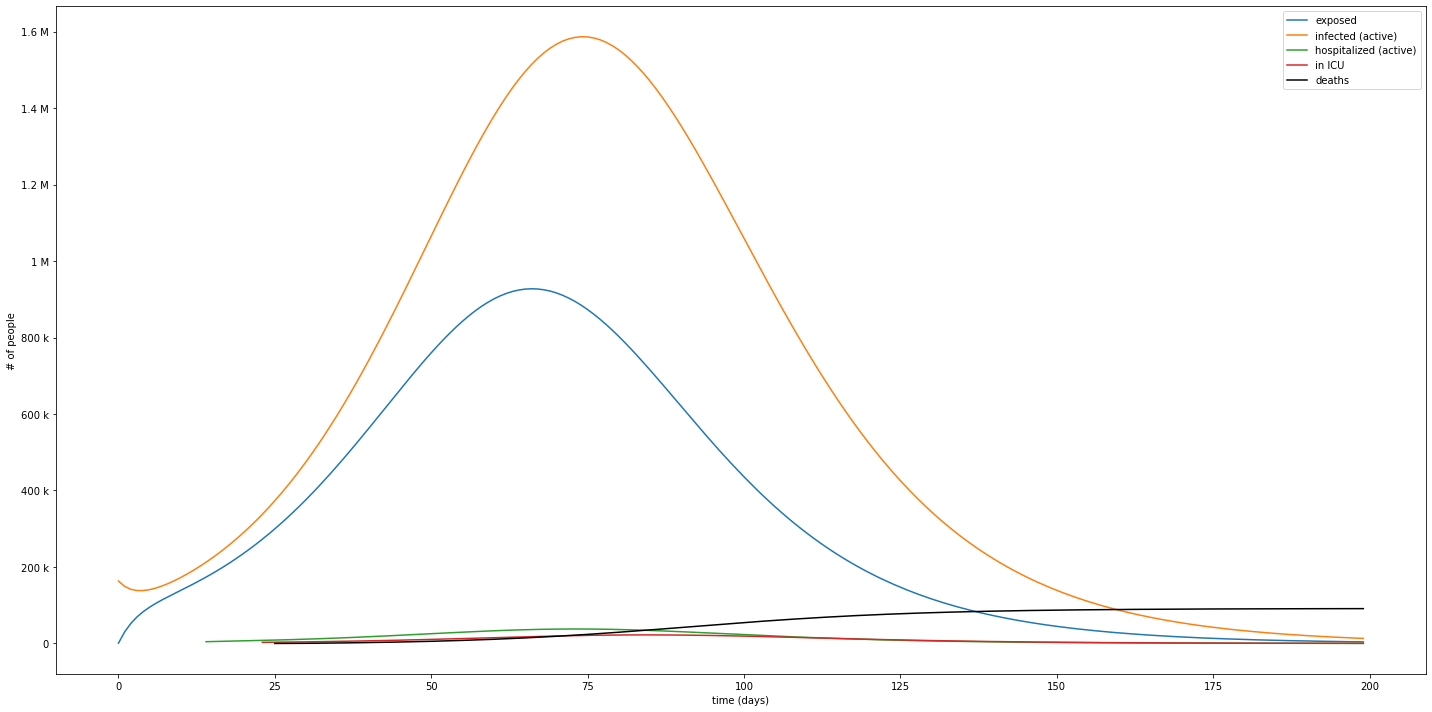

In [17]:
run_model('show')

In [19]:
df = pd.DataFrame()
n=0
max_simulation_time = 60
for i in rivm_per_day.index:
    try:
        r['Rt_avg'][i]
    except:
        pass
    else:
        initial_R0 = r['Rt_avg'][i]
        hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        icu_probability = rivm_per_day.loc[:i,'IC_admission'].sum()/rivm_per_day.loc[:i,'Positive_tests'].sum()
        death_probability = rivm_per_day.loc[:i,'Deceased_covid'].sum()/rivm_per_day.loc[:i,'Positive_tests'].sum()
        p = str(rivm_per_day.index[ni].year * 100 + rivm_per_day.index[ni].month)
        p = e[:4] + '-' + e[-2:]
        population = population_per_month.loc[p,'Population']
        # Setup initial state
        population_exposed = ( rivm_per_day.loc[i + pd.Timedelta(days=-7):i,'Positive_tests'].sum() / 7) / population
        population_infected = ( rivm_per_day.loc[i + pd.Timedelta(days=-7):i,'prev_avg'].sum() / 7) / population
        probabilities = True

        run_model()
        results['time'] = results[ 'time'].astype(int)
        results['i'] = i
        results['time'] = results.apply(lambda x: x['i'] + pd.Timedelta(days=x['time']), axis=1)
        results['time'] = results['time'].astype(str)
        n+=1
        df = df.append(results)
df.reset_index(inplace=True, drop=True)
df

/tmp/ipykernel_29887/3497095173.py:11: RuntimeWarning: invalid value encountered in double_scalars
  hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/tmp/ipykernel_29887/3497095173.py:12: RuntimeWarning: invalid value encountered in double_scalars
  icu_probability = rivm_per_day.loc[:i,'IC_admission'].sum()/rivm_per_day.loc[:i,'Positive_tests'].sum()
/tmp/ipykernel_29887/3497095173.py:13: RuntimeWarning: invalid value encountered in double_scalars
  death_probability = rivm_per_day.loc[:i,'Deceased_covid'].sum()/rivm_per_day.loc[:i,'Positive_tests'].sum()
/tmp/ipykernel_29887/3497095173.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/home/cjvanzwol/miniconda3/envs/covid/lib/python3.9/site-packages/SEIR/seir.py:507: RuntimeWarning: invalid value encountered in multiply
  n

time  (susceptible, All)   susceptible  (exposed, All)  \
0      2020-02-17        1.742410e+07  1.742410e+07        0.000000   
1      2020-02-18        1.742407e+07  1.742407e+07       28.372813   
2      2020-02-19        1.742404e+07  1.742404e+07       49.664394   
3      2020-02-20        1.742401e+07  1.742401e+07       66.146833   
4      2020-02-21        1.742399e+07  1.742399e+07       79.399175   
...           ...                 ...           ...             ...   
39115  2022-01-23        1.718872e+07  1.718872e+07        0.426478   
39116  2022-01-24        1.718872e+07  1.718872e+07        0.349171   
39117  2022-01-25        1.718872e+07  1.718872e+07        0.285877   
39118  2022-01-26        1.718872e+07  1.718872e+07        0.234056   
39119  2022-01-27        1.718872e+07  1.718872e+07        0.191629   

         exposed  (infected (active), All)  infected (active)  \
0       0.000000                153.428571         153.428571   
1      28.372813                140.162923         140.162923   
2      49.664394                132.937719         132.937719   
3      66.146833                130.009387         130.009387   
4      79.399175                130.176979         130.176979   
...          ...                       ...                ...   
39115   0.426478                592.290659         592.290659   
39116   0.349171                530.078000         530.078000   
39117   0.285877                474.394429         474.394429   
39118   0.234056                424.555742         424.555742   
39119   0.191629                379.949250         379.949250   

       (infected (total), All)  infected (total)  (removed, All)  \
0                   153.428571        153.428571        0.000000   
1                   156.265853        156.265853       16.244591   
2                   164.069573        164.069573       31.370085   
3                   175.650696        175.650696       45.944790   
4                   190.205297        190.205297       60.375267   
...                        ...               ...             ...   
39115            235626.443608     235626.443608   234949.094394   
39116            235626.521173     235626.521173   235011.384360   
39117            235626.584678     235626.584678   235067.131225   
39118            235626.636671     235626.636671   235117.021733   
39119            235626.679239     235626.679239   235161.670651   

             removed  (hospitalized (active), All)  hospitalized (active)  \
0           0.000000                           NaN                    NaN   
1          16.244591                           NaN                    NaN   
2          31.370085                           NaN                    NaN   
3          45.944790                           NaN                    NaN   
4          60.375267                           NaN                    NaN   
...              ...                           ...                    ...   
39115  234949.094394                      0.081087               0.081087   
39116  235011.384360                      0.066389               0.066389   
39117  235067.131225                      0.055227               0.055227   
39118  235117.021733                      0.046088               0.046088   
39119  235161.670651                      0.038606               0.038606   

       (in ICU, All)     in ICU  (deaths, All)      deaths           i  
0                NaN        NaN            NaN         NaN  2020-02-17  
1                NaN        NaN            NaN         NaN  2020-02-17  
2                NaN        NaN            NaN         NaN  2020-02-17  
3                NaN        NaN            NaN         NaN  2020-02-17  
4                NaN        NaN            NaN         NaN  2020-02-17  
...              ...        ...            ...         ...         ...  
39115      29.810434  29.810434     188.690834  188.690834  2021-11-29  
39116      26.827038  26.827038     188.775828  188.7

In [5]:
#rcParams['figure.figsize'] = 20,100
#df.plot(subplots=True,kind='bar')

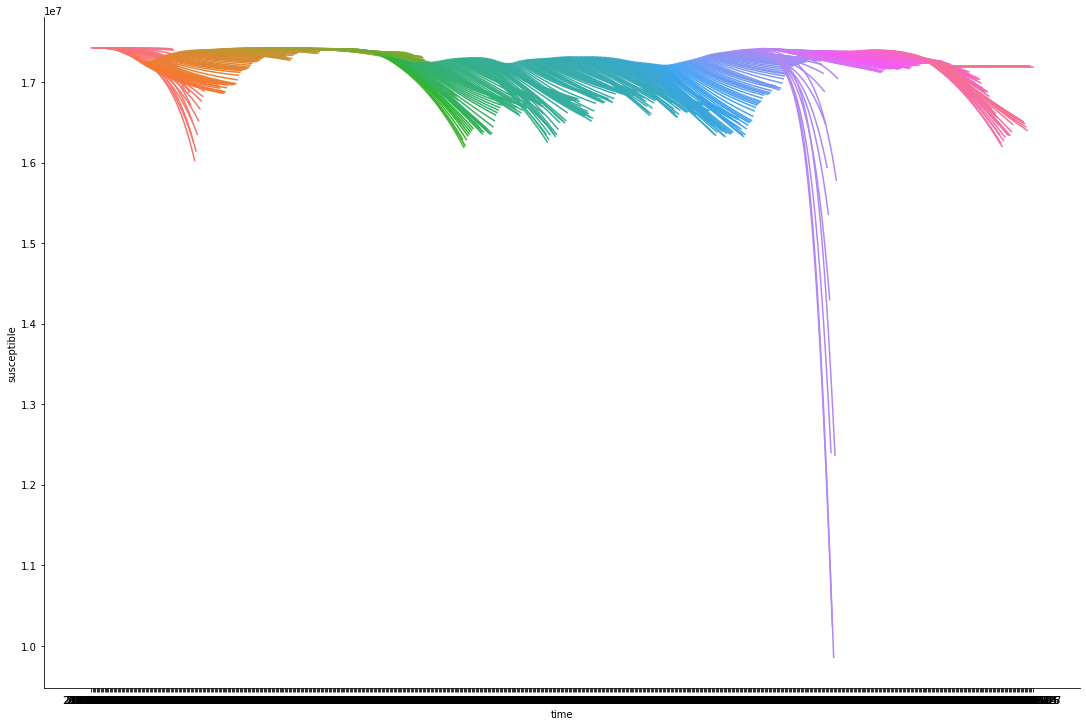

In [20]:
sns.relplot(
    data=df,
    x="time", y="susceptible",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

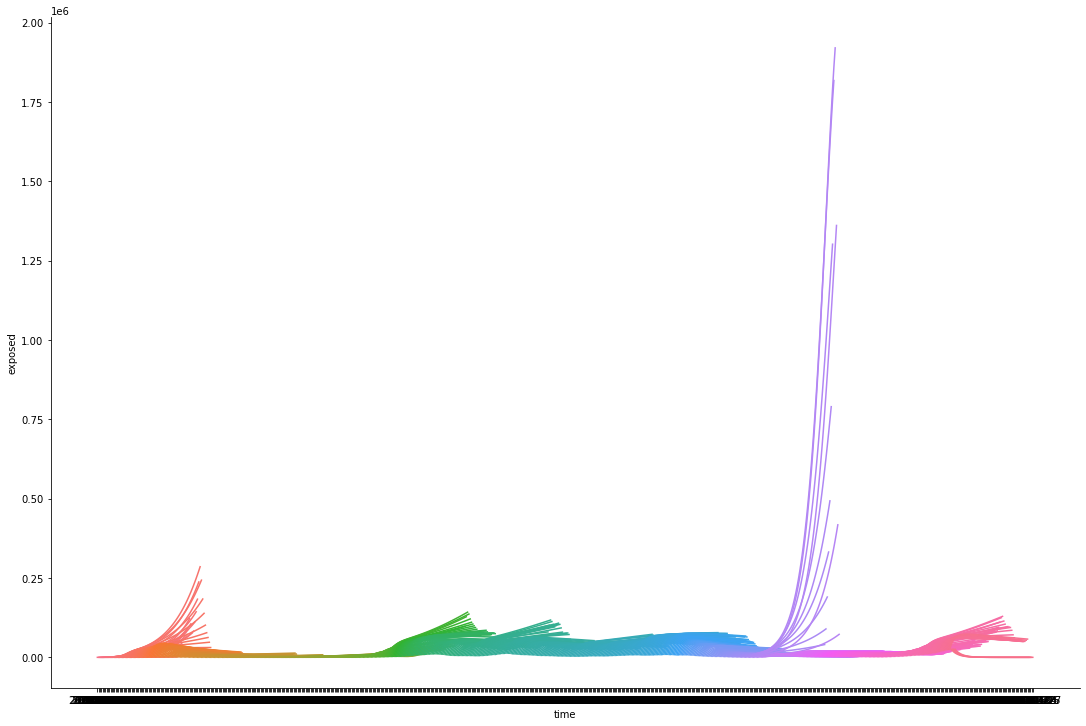

In [21]:
sns.relplot(
    data=df,
    x="time", y="exposed",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

<AxesSubplot:xlabel='Date'>

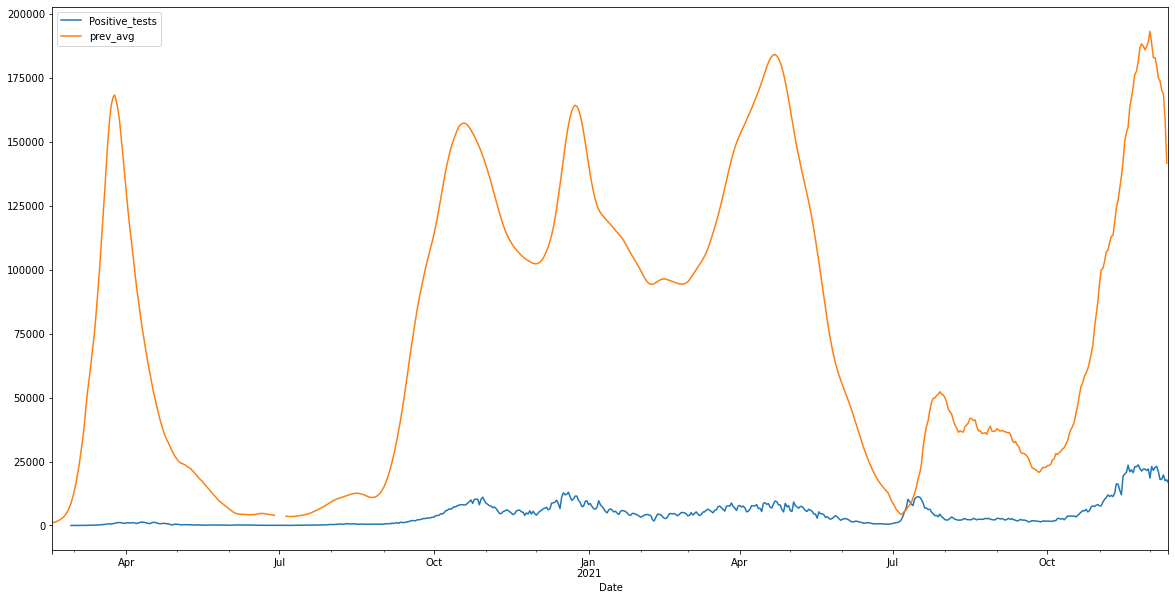

In [22]:
rcParams['figure.figsize'] = 20,10
rivm_per_day[['Positive_tests','prev_avg']].plot()

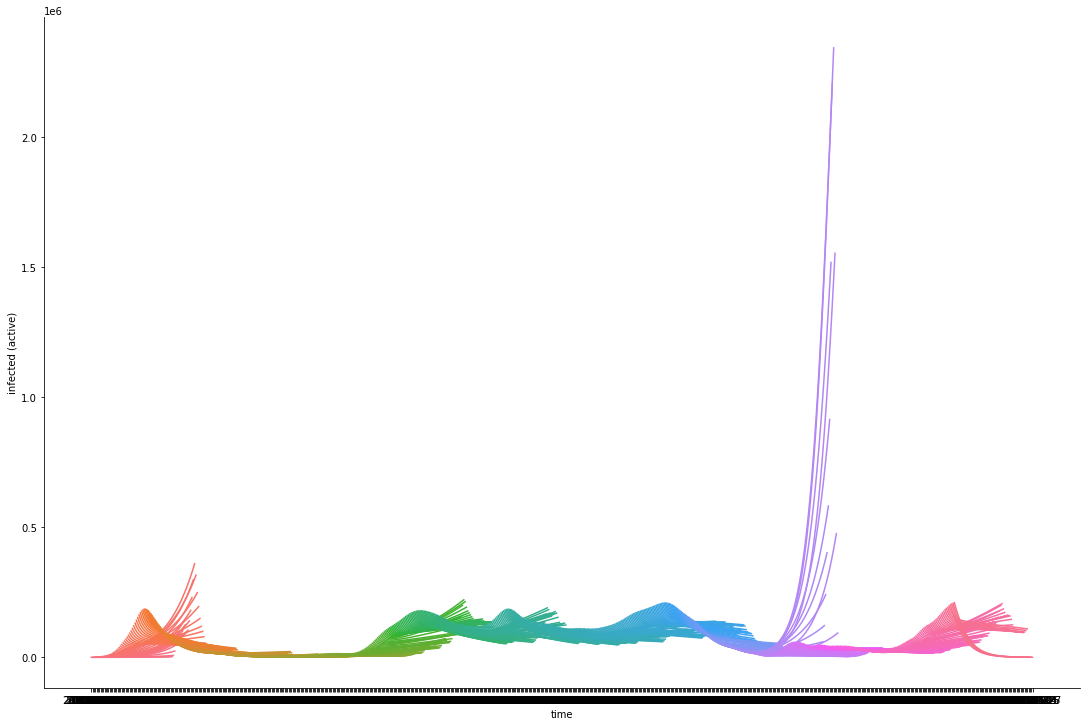

In [23]:
sns.relplot(
    data=df,
    x="time", y="infected (active)",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

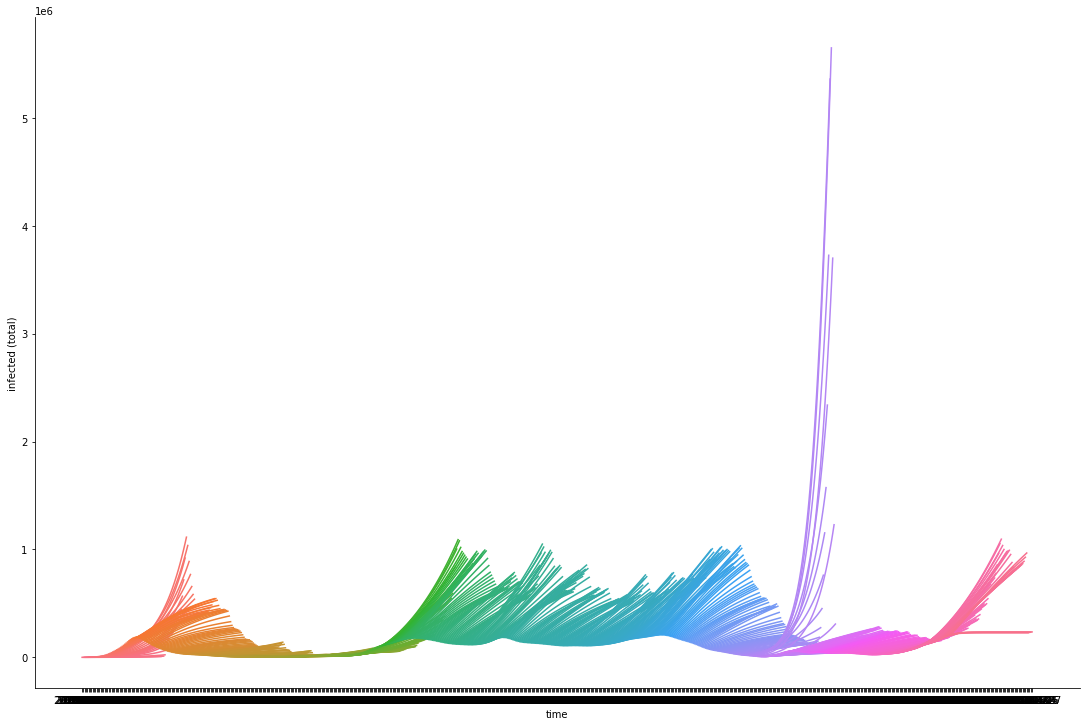

In [24]:
sns.relplot(
    data=df,
    x="time", y="infected (total)",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

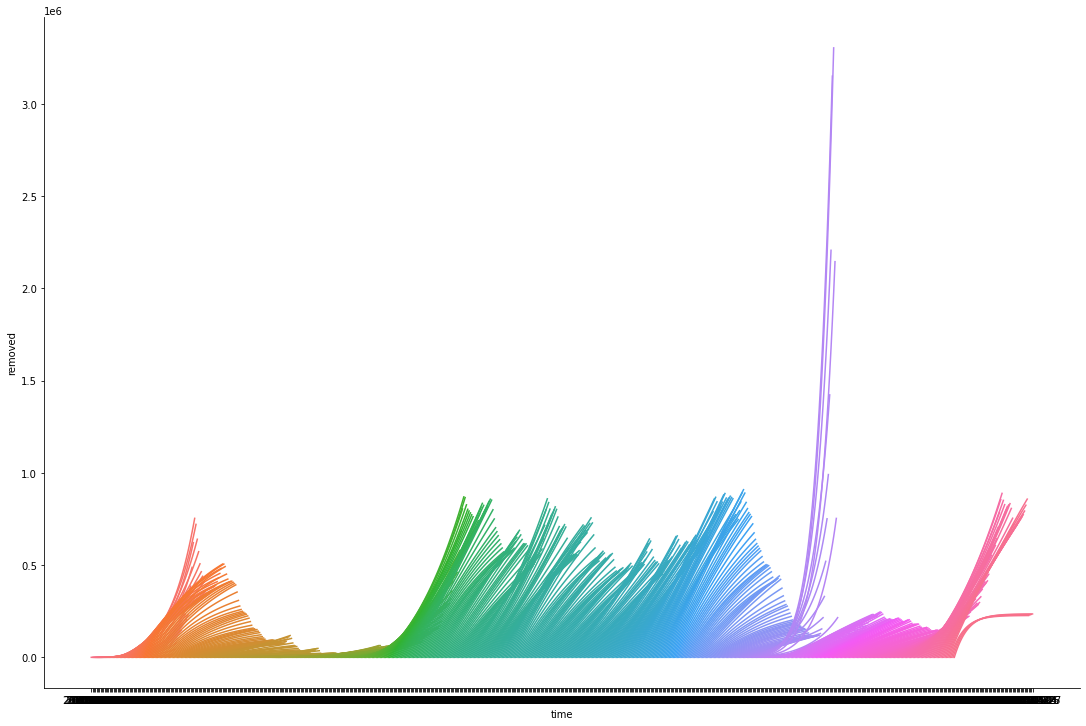

In [25]:
sns.relplot(
    data=df,
    x="time", y="removed",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

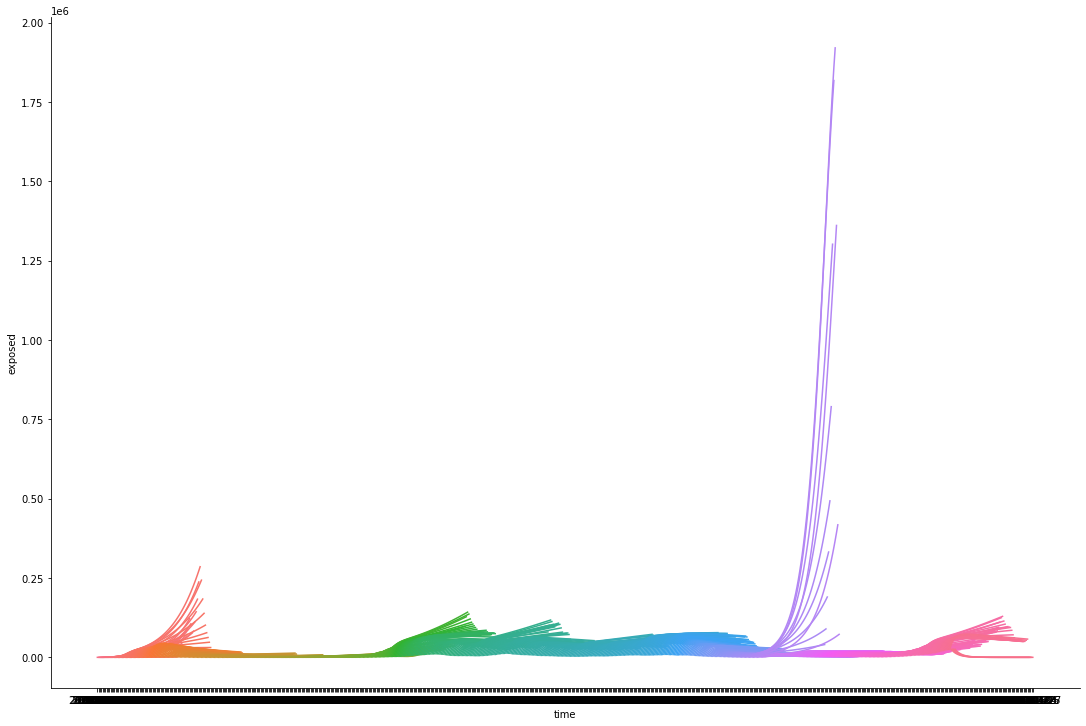

In [26]:
sns.relplot(
    data=df,
    x="time", y="exposed",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

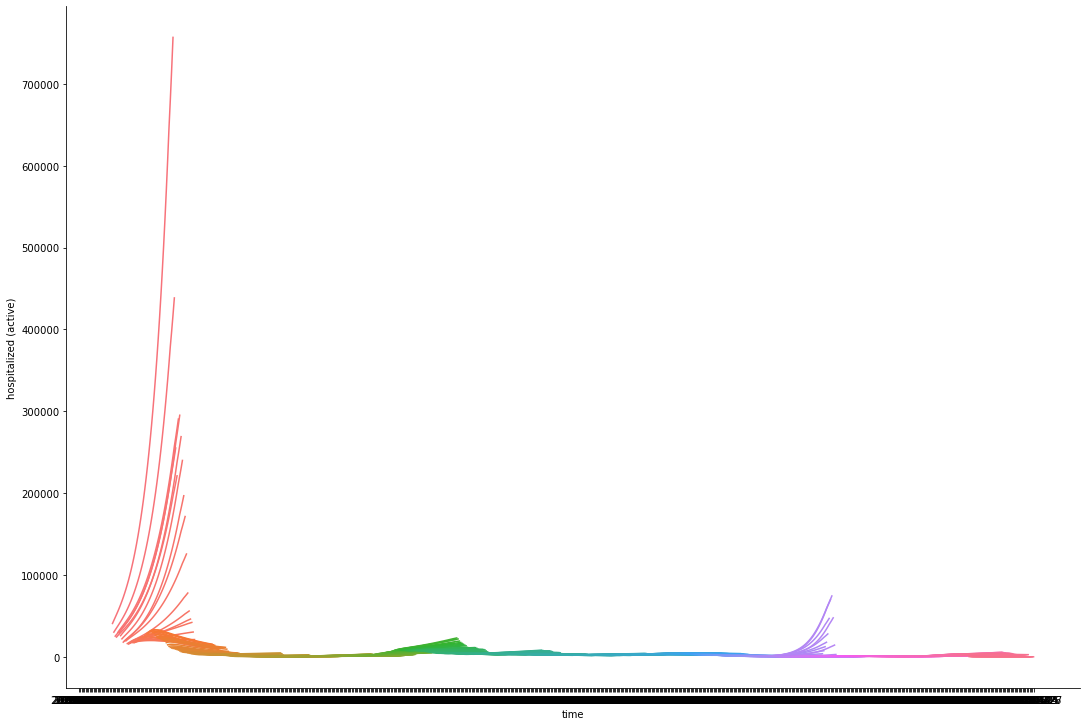

In [27]:
sns.relplot(
    data=df,
    x="time", y="hospitalized (active)",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

<AxesSubplot:xlabel='Date'>

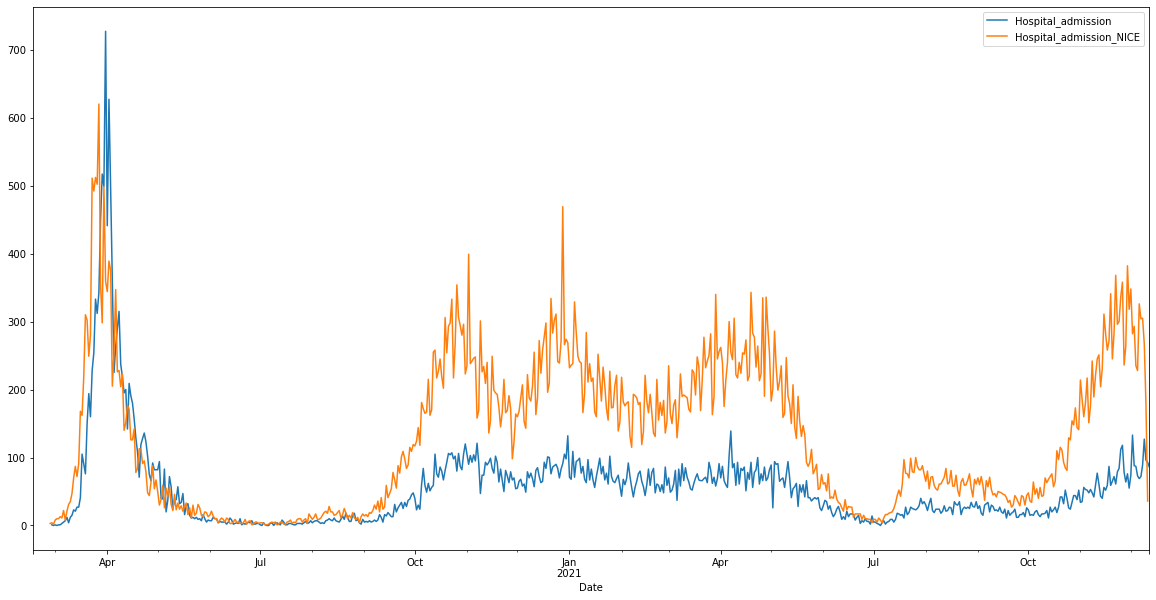

In [28]:
rivm_per_day[['Hospital_admission','Hospital_admission_NICE']].plot()

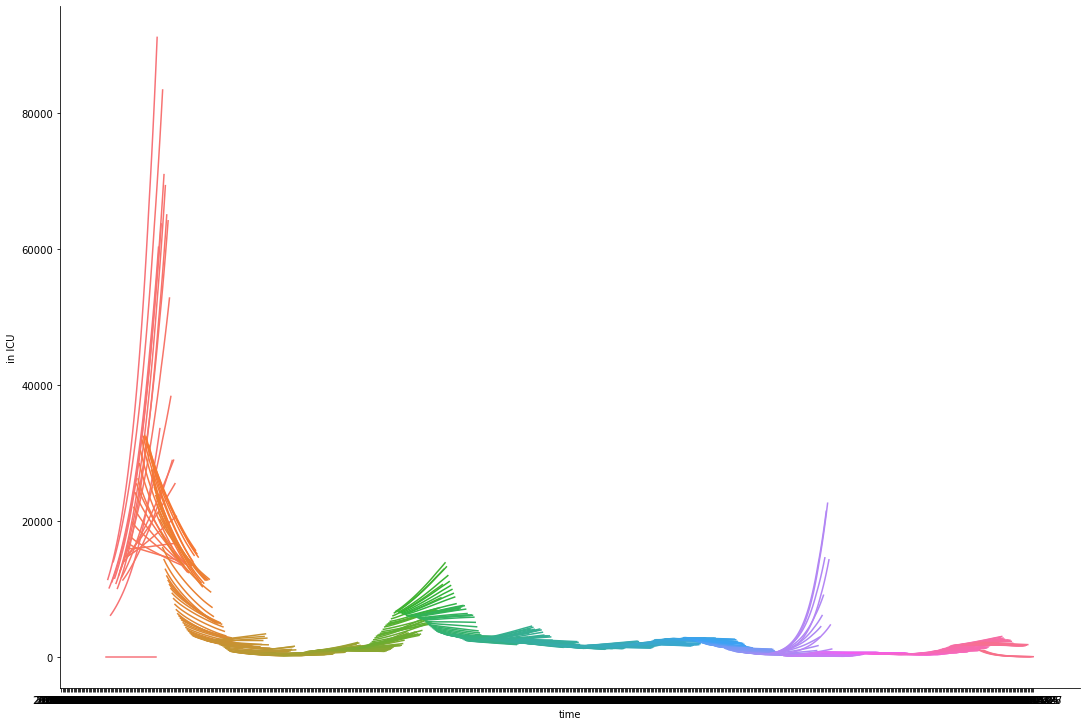

In [29]:
sns.relplot(
    data=df,
    x="time", y="in ICU",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

<AxesSubplot:xlabel='Date'>

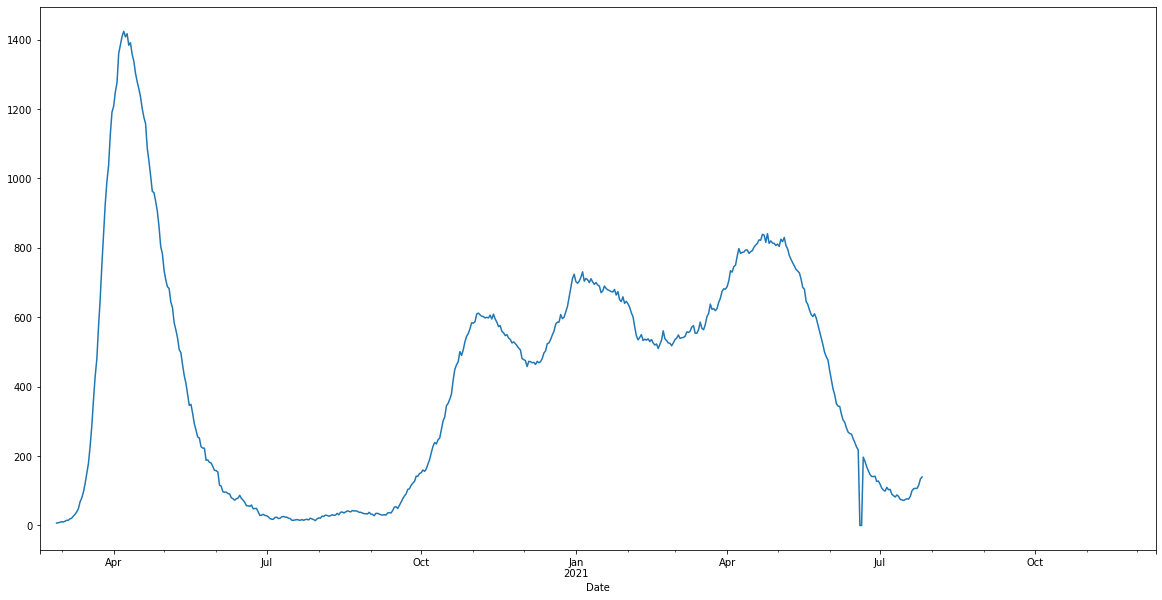

In [30]:
rivm_per_day['IC_Bedden_COVID'].plot()

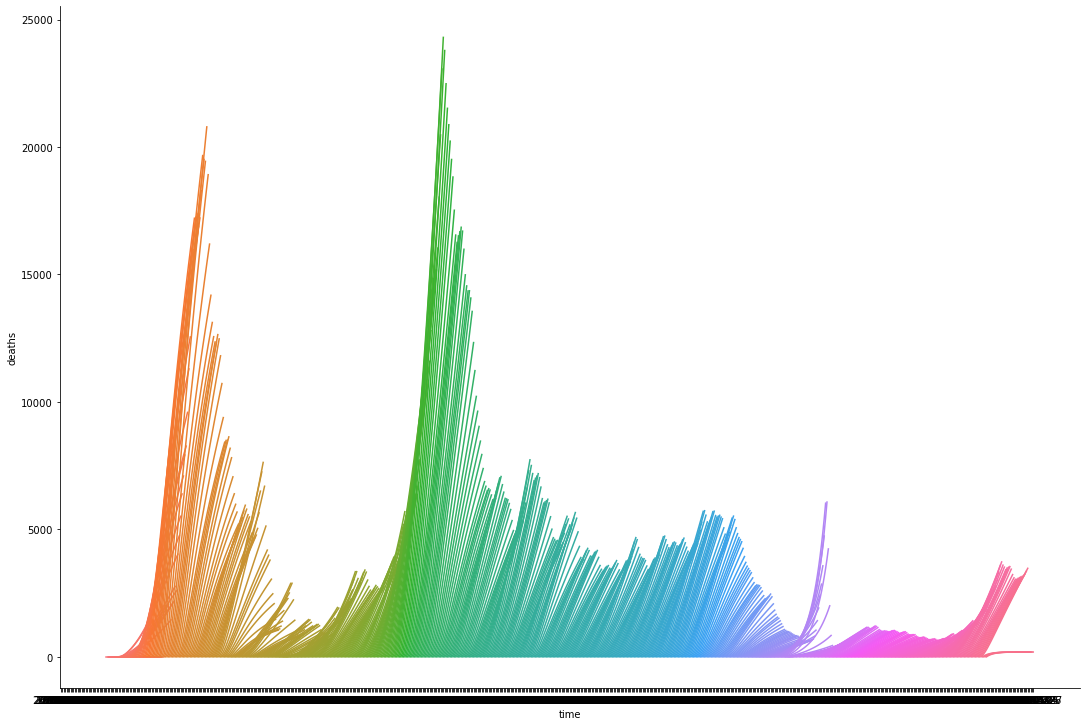

In [31]:
sns.relplot(
    data=df,
    x="time", y="deaths",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

<AxesSubplot:xlabel='Date'>

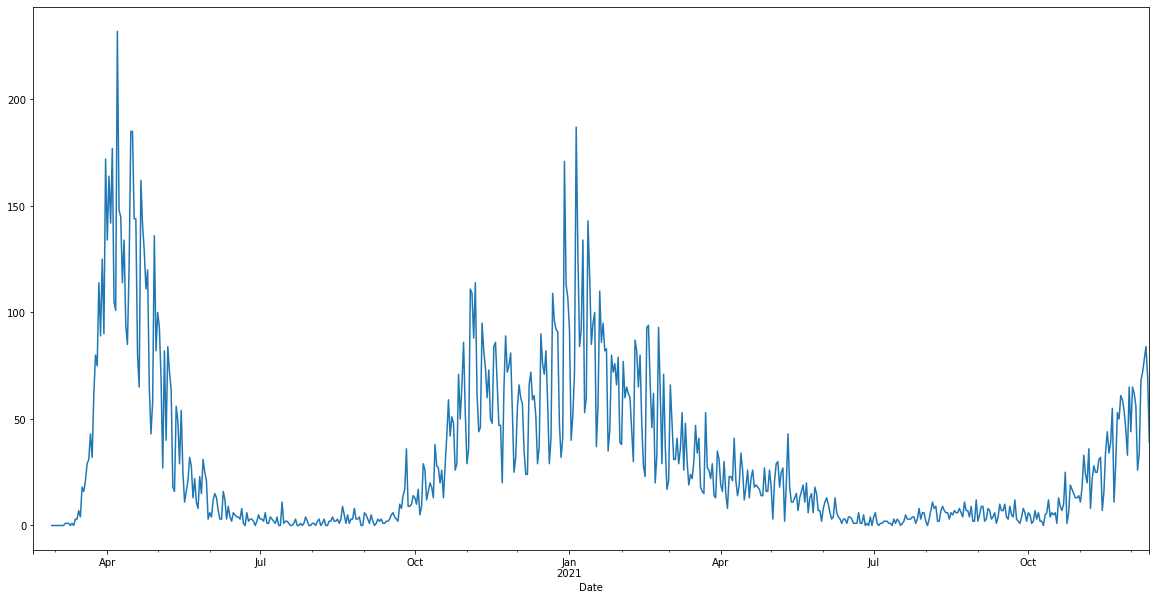

In [32]:
rivm_per_day['Deceased_covid'].plot()

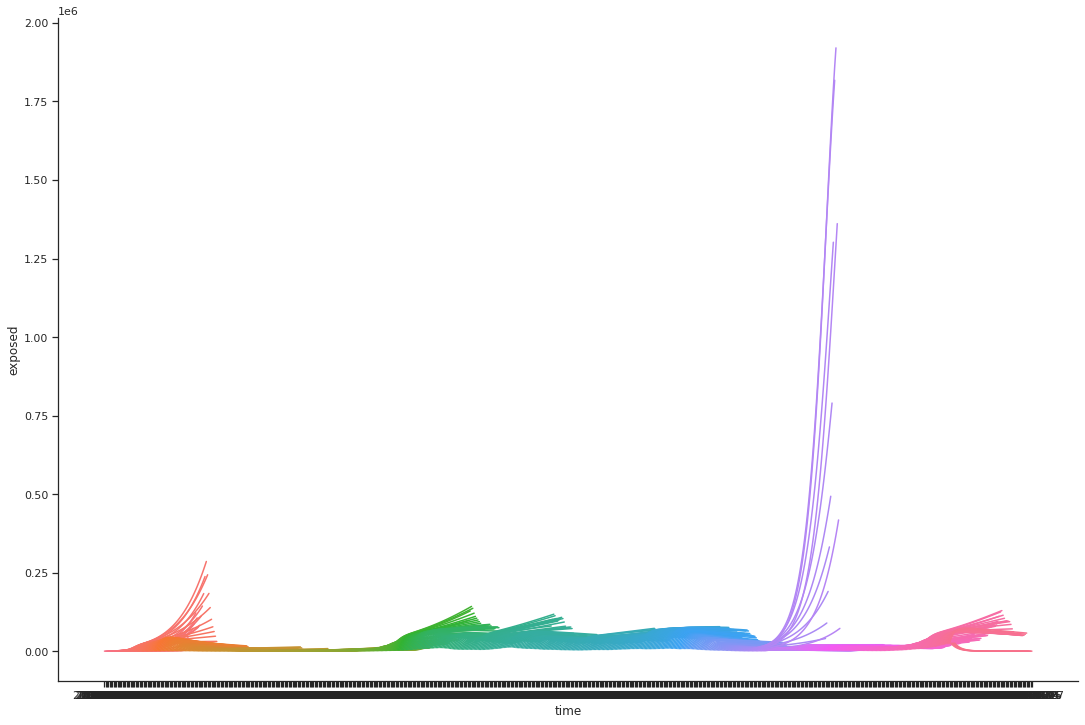

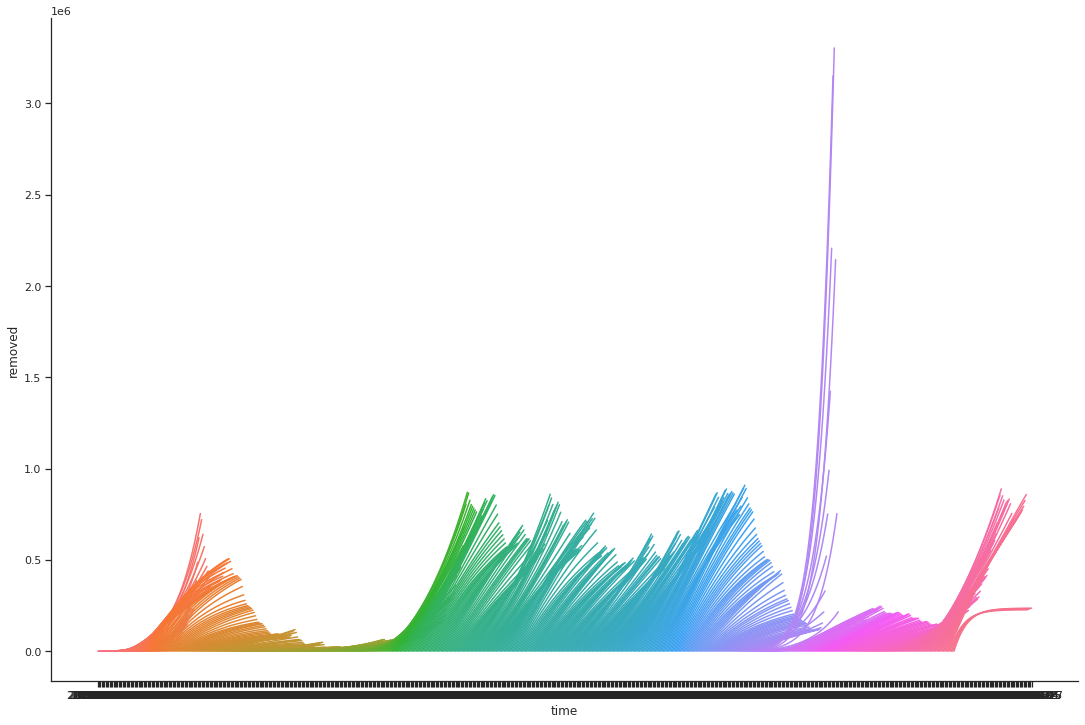

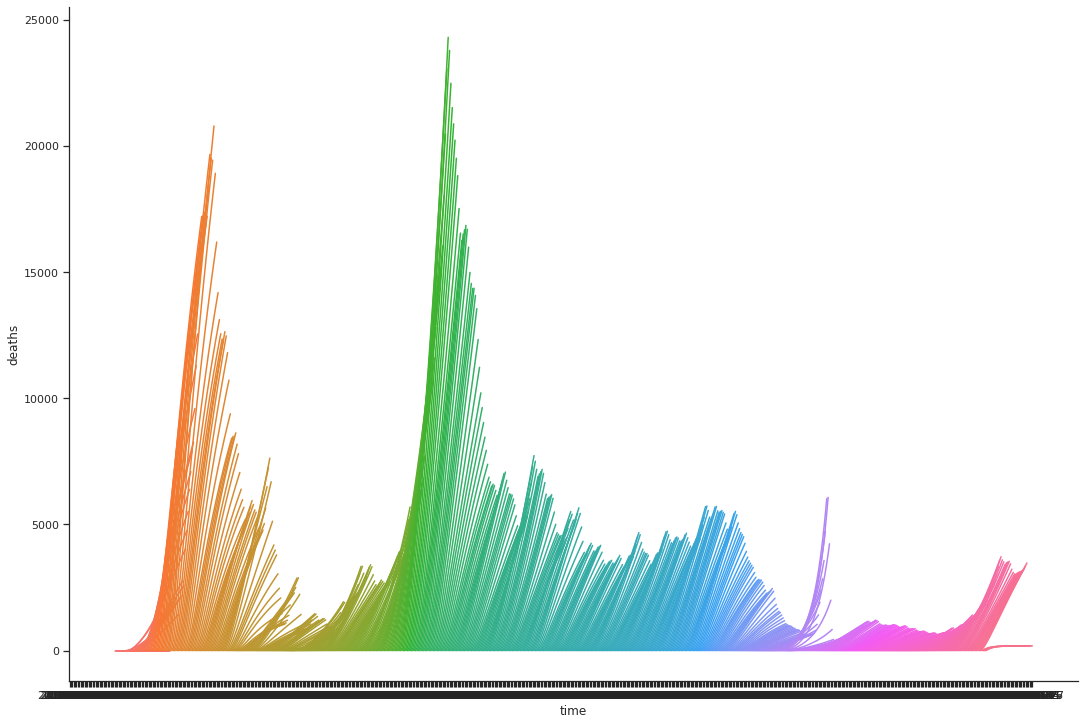

In [33]:
sns.set_theme(style="ticks")

for c in df.columns:
    if c.__contains__('All') or c.__contains__('time') or c.__contains__('i'):
        pass
    else:
        # Plot the lines on two facets
        sns.relplot(
            data=df,
            x="time", y=c,
            hue="i",
            kind="line",
            height=10, aspect=1.5, 
            facet_kws=dict(sharex=False),
            legend=False
        )

In [34]:
df2 = pd.DataFrame()
n=0
max_simulation_time = 60
for i in rivm_per_day.index:
    try:
        r['Rt_avg'][i]
    except:
        pass
    else:
        f = i + pd.Timedelta(days=-max_simulation_time)
        initial_R0 = r['Rt_avg'][i]
        hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        icu_probability = rivm_per_day['IC_admission'][f:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        death_probability = rivm_per_day['Deceased_covid'][f:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        p = str(rivm_per_day.index[ni].year * 100 + rivm_per_day.index[ni].month)
        p = e[:4] + '-' + e[-2:]
        population = population_per_month.loc[p,'Population']
        # Setup initial state
        population_exposed = rivm_per_day.loc[i + pd.Timedelta(days=-7):i,'Positive_tests'].sum() / population
        population_infected = rivm_per_day.loc[i + pd.Timedelta(days=-7):i,'prev_avg'].sum() / population
        probabilities = True

        run_model()
        results['time'] = results[ 'time'].astype(int)
        results['i'] = i
        results['time'] = results.apply(lambda x: x['i'] + pd.Timedelta(days=x['time']), axis=1)
        results['time'] = results['time'].astype(str)
        n+=1
        df2 = df2.append(results)
df2.reset_index(inplace=True, drop=True)
df2

/tmp/ipykernel_29887/239506404.py:12: RuntimeWarning: invalid value encountered in double_scalars
  hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/tmp/ipykernel_29887/239506404.py:13: RuntimeWarning: invalid value encountered in double_scalars
  icu_probability = rivm_per_day['IC_admission'][f:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/tmp/ipykernel_29887/239506404.py:14: RuntimeWarning: invalid value encountered in double_scalars
  death_probability = rivm_per_day['Deceased_covid'][f:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/tmp/ipykernel_29887/239506404.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/home/cjvanzwol/miniconda3/envs/covid/lib/python3.9/site-packages/SEIR/seir.py:507: RuntimeWarning: invalid value encountered in multiply
  np.multiply(sel

time  (susceptible, All)   susceptible  (exposed, All)  \
0      2020-02-17        1.742318e+07  1.742318e+07        0.000000   
1      2020-02-18        1.742296e+07  1.742296e+07      198.598014   
2      2020-02-19        1.742276e+07  1.742276e+07      347.627948   
3      2020-02-20        1.742256e+07  1.742256e+07      462.993813   
4      2020-02-21        1.742237e+07  1.742237e+07      555.748336   
...           ...                 ...           ...             ...   
39115  2022-01-23        1.577546e+07  1.577546e+07        2.985346   
39116  2022-01-24        1.577546e+07  1.577546e+07        2.444194   
39117  2022-01-25        1.577546e+07  1.577546e+07        2.001137   
39118  2022-01-26        1.577546e+07  1.577546e+07        1.638392   
39119  2022-01-27        1.577546e+07  1.577546e+07        1.341402   

          exposed  (infected (active), All)  infected (active)  \
0        0.000000               1074.000000        1074.000000   
1      198.598014                981.139323         981.139323   
2      347.627948                930.559724         930.559724   
3      462.993813                910.056466         910.056466   
4      555.748336                911.223013         911.223013   
...           ...                       ...                ...   
39115    2.985346               4146.034611        4146.034611   
39116    2.444194               3710.546002        3710.546002   
39117    2.001137               3320.761004        3320.761004   
39118    1.638392               2971.890191        2971.890191   
39119    1.341402               2659.644753        2659.644753   

       (infected (total), All)  infected (total)  (removed, All)  \
0                 1.074000e+03      1.074000e+03    0.000000e+00   
1                 1.093860e+03      1.093860e+03    1.137121e+02   
2                 1.148482e+03      1.148482e+03    2.195903e+02   
3                 1.229545e+03      1.229545e+03    3.216125e+02   
4                 1.331419e+03      1.331419e+03    4.226244e+02   
...                        ...               ...             ...   
39115             1.649385e+06      1.649385e+06    1.644644e+06   
39116             1.649386e+06      1.649386e+06    1.645080e+06   
39117             1.649386e+06      1.649386e+06    1.645470e+06   
39118             1.649386e+06      1.649386e+06    1.645819e+06   
39119             1.649387e+06      1.649387e+06    1.646132e+06   

            removed  (hospitalized (active), All)  hospitalized (active)  \
0      0.000000e+00                           NaN                    NaN   
1      1.137121e+02                           NaN                    NaN   
2      2.195903e+02                           NaN                    NaN   
3      3.216125e+02                           NaN                    NaN   
4      4.226244e+02                           NaN                    NaN   
...             ...                           ...                    ...   
39115  1.644644e+06                      0.567611               0.567611   
39116  1.645080e+06                      0.464721               0.464721   
39117  1.645470e+06                      0.386586               0.386586   
39118  1.645819e+06                      0.322614               0.322614   
39119  1.646132e+06                      0.270239               0.270239   

       (in ICU, All)     in ICU  (deaths, All)     deaths           i  
0                NaN        NaN            NaN        NaN  2020-02-17  
1                NaN        NaN            NaN        NaN  2020-02-17  
2                NaN        NaN            NaN        NaN  2020-02-17  
3                NaN        NaN            NaN        NaN  2020-02-17  
4                NaN        NaN            NaN        NaN  2020-02-17  
...              ...        ...            ...        ...         ...  
39115      21.989349  21.989349      80.619522  80.619522  2021-11-29  
39116      19.788679  19.788679      80.655836  80.655836  20

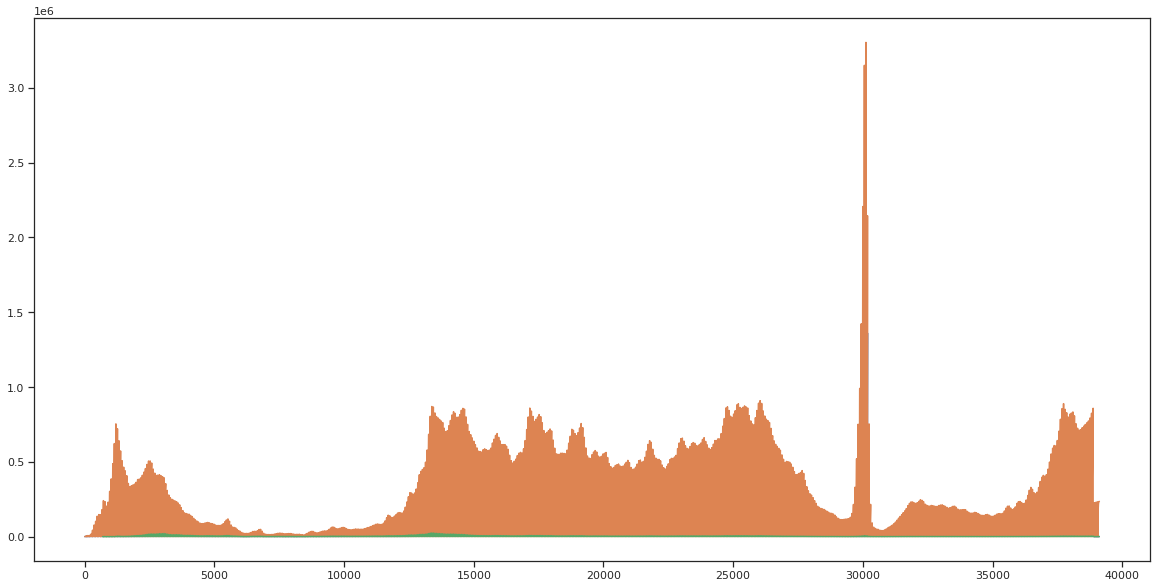

In [35]:
for c in df.columns:
    if c.__contains__('All') or c.__contains__('time') or c.__contains__('i'):
        pass
    else:
        df[c].plot()

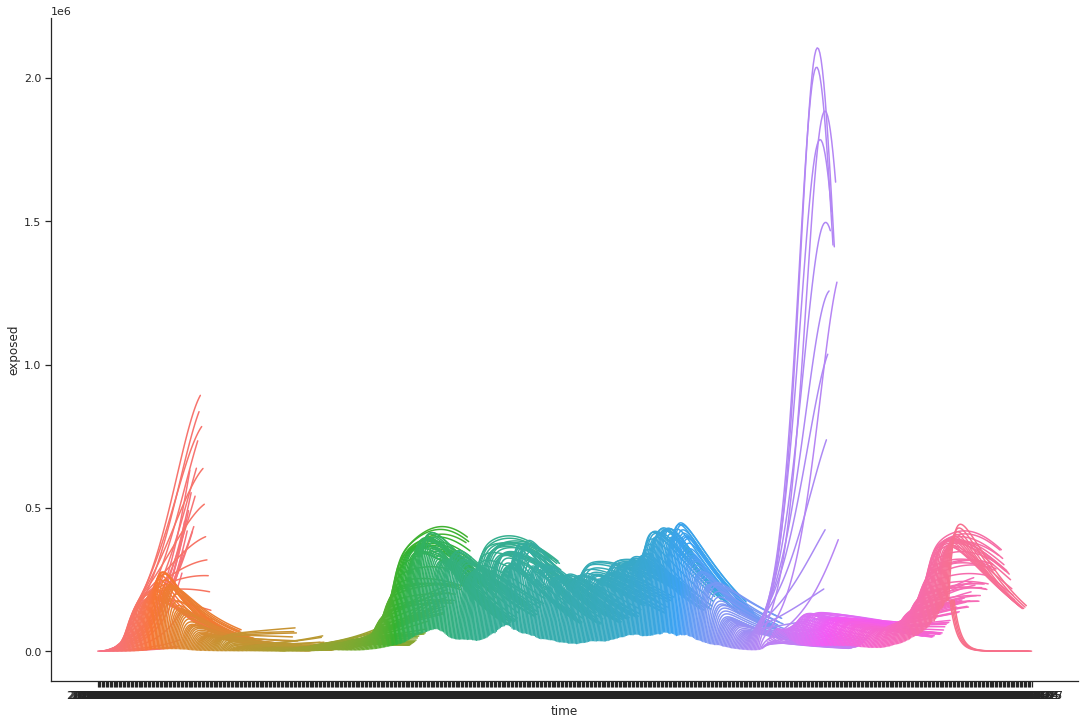

In [36]:
sns.relplot(
    data=df2,
    x="time", y="exposed",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

TypeError: float() argument must be a string or a number, not 'Period'

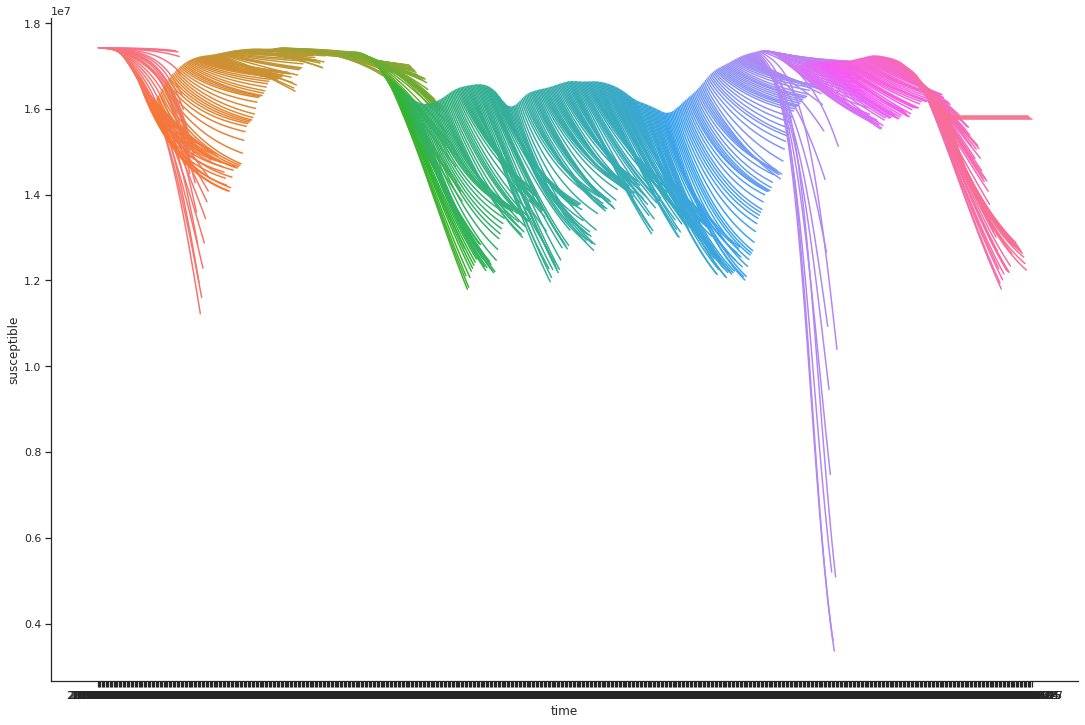

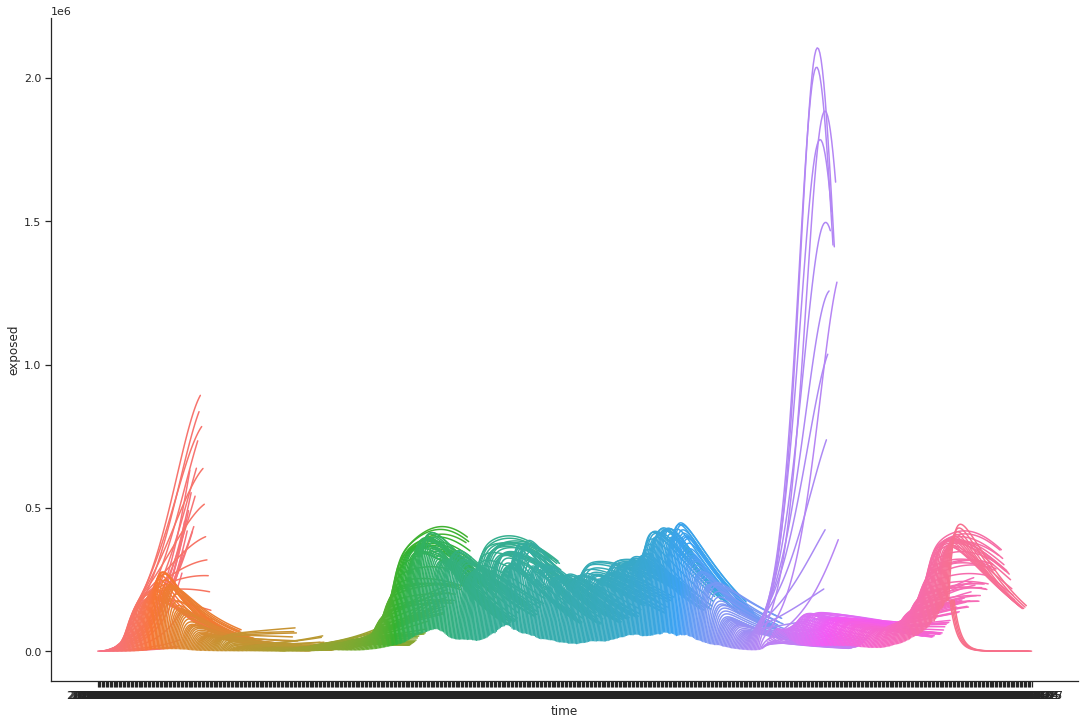

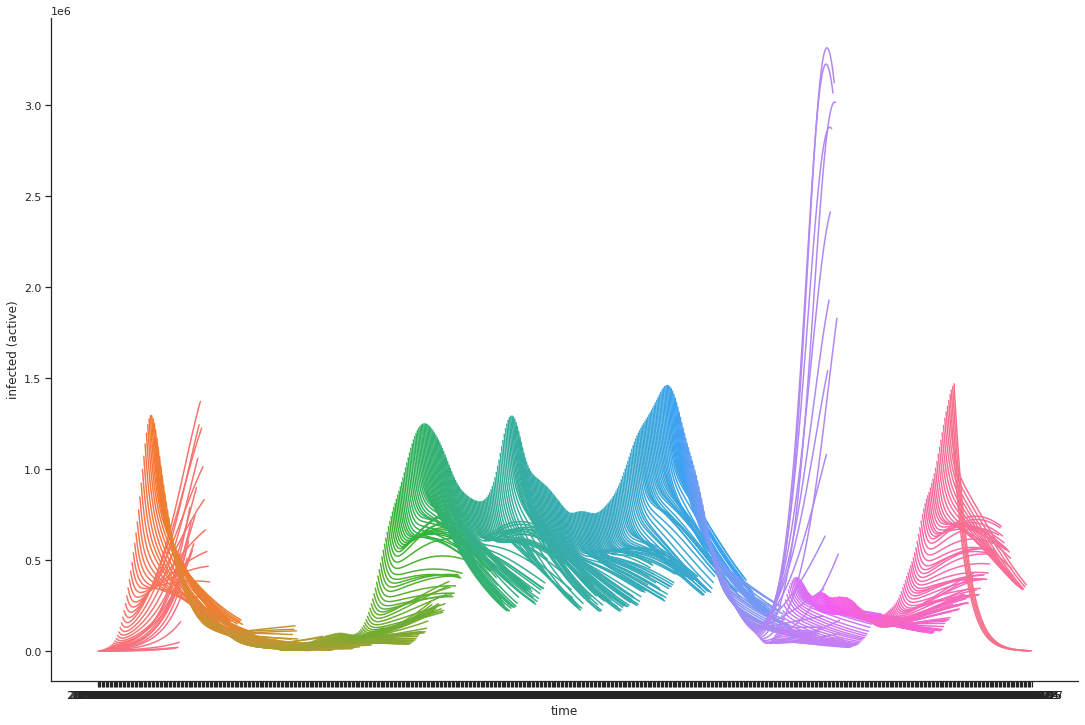

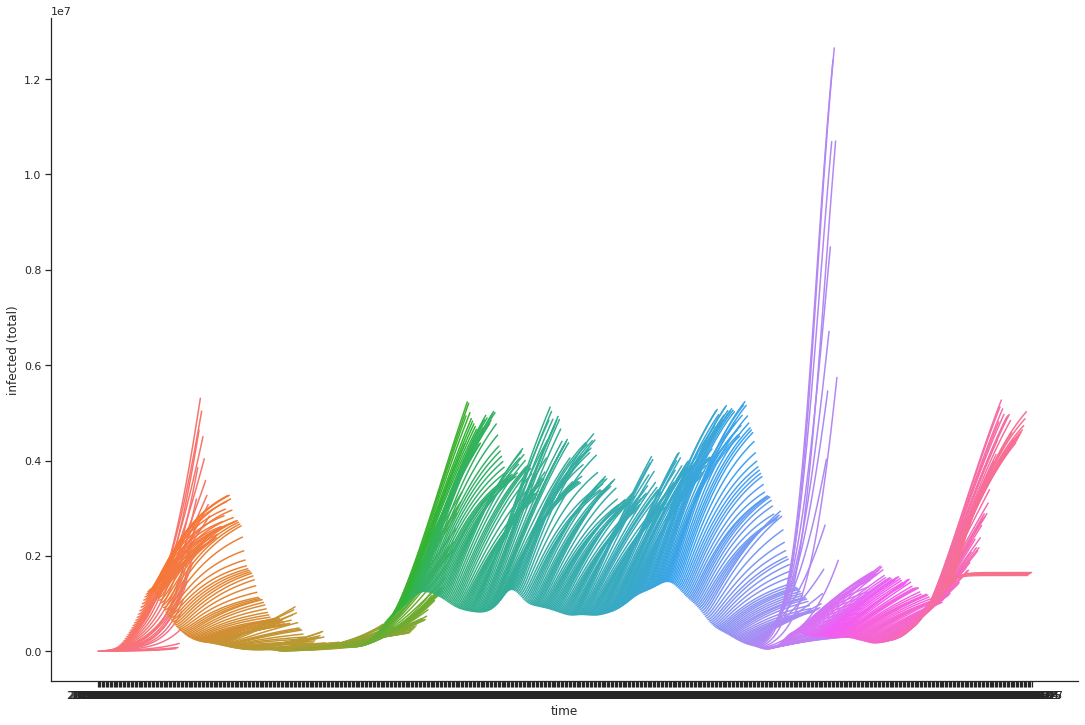

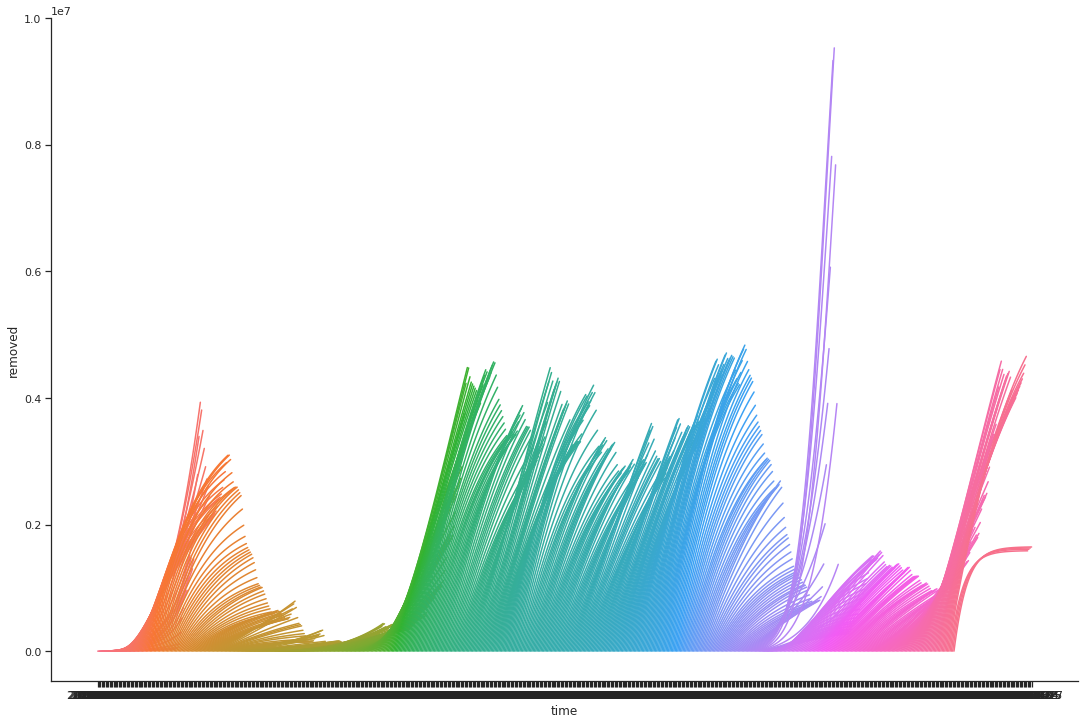

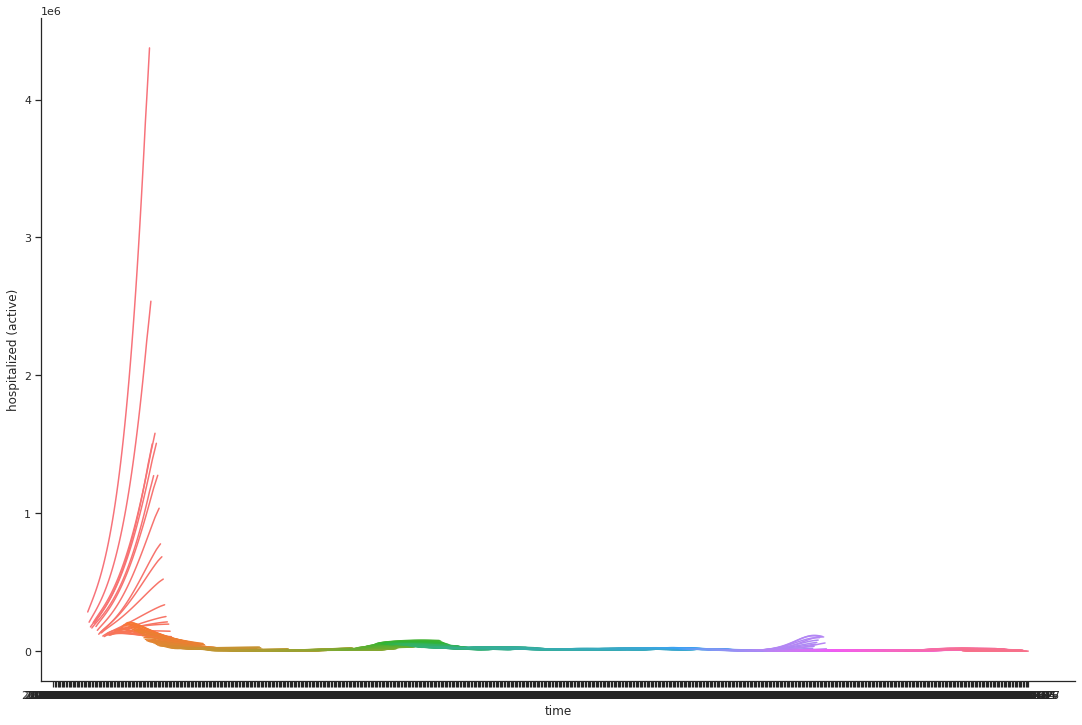

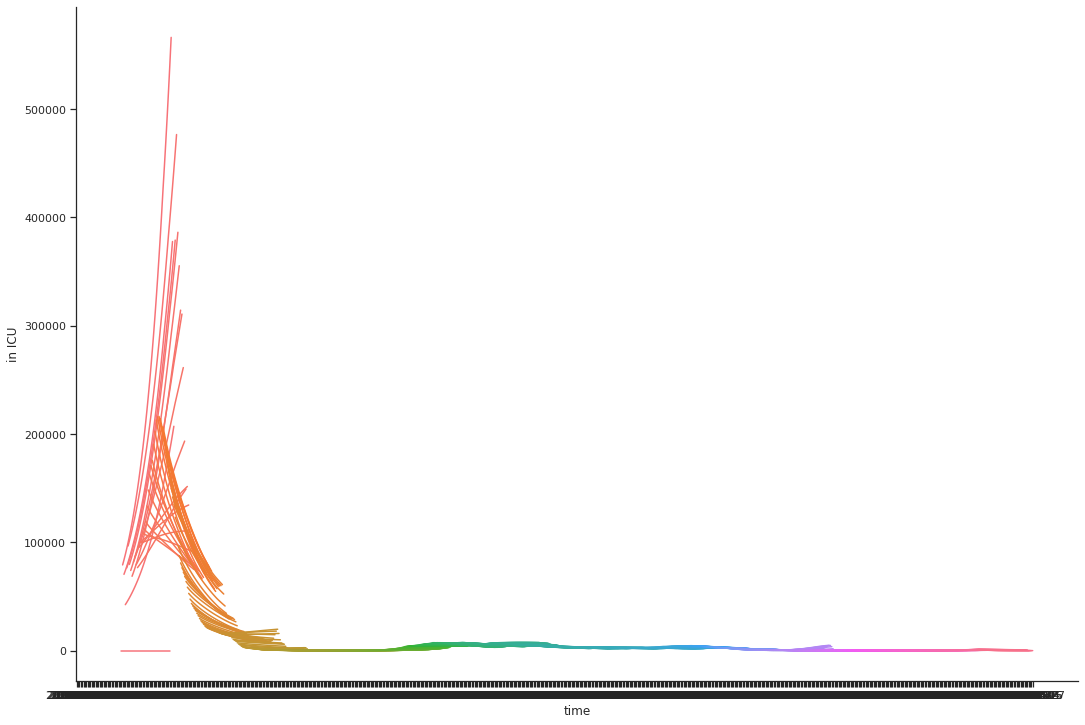

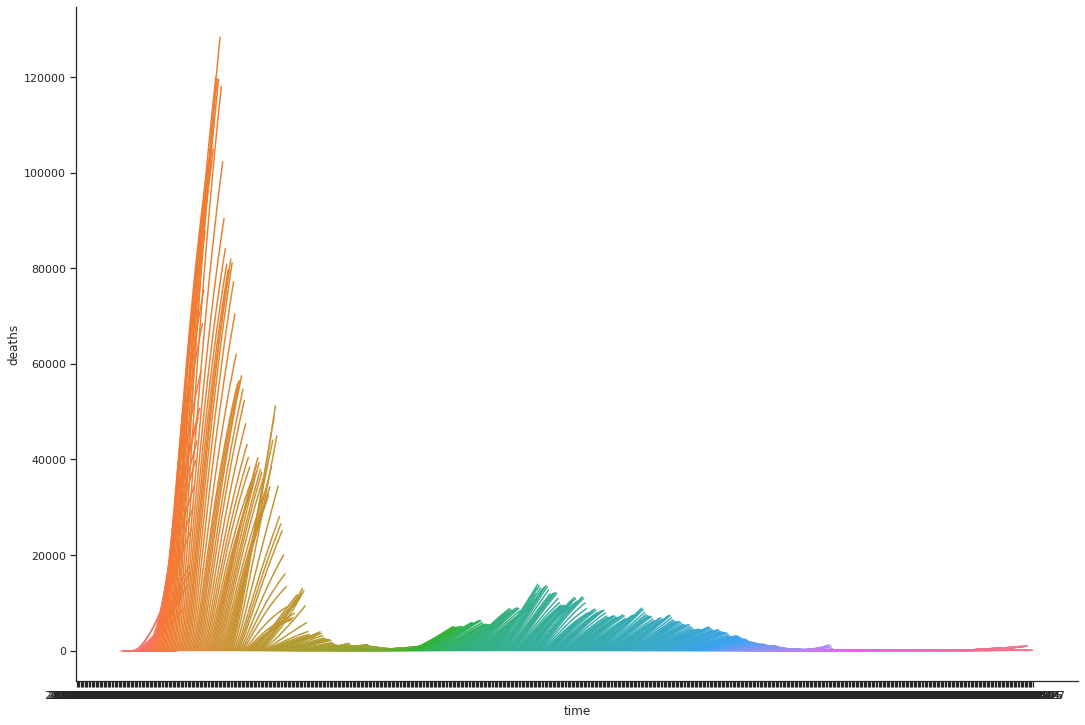

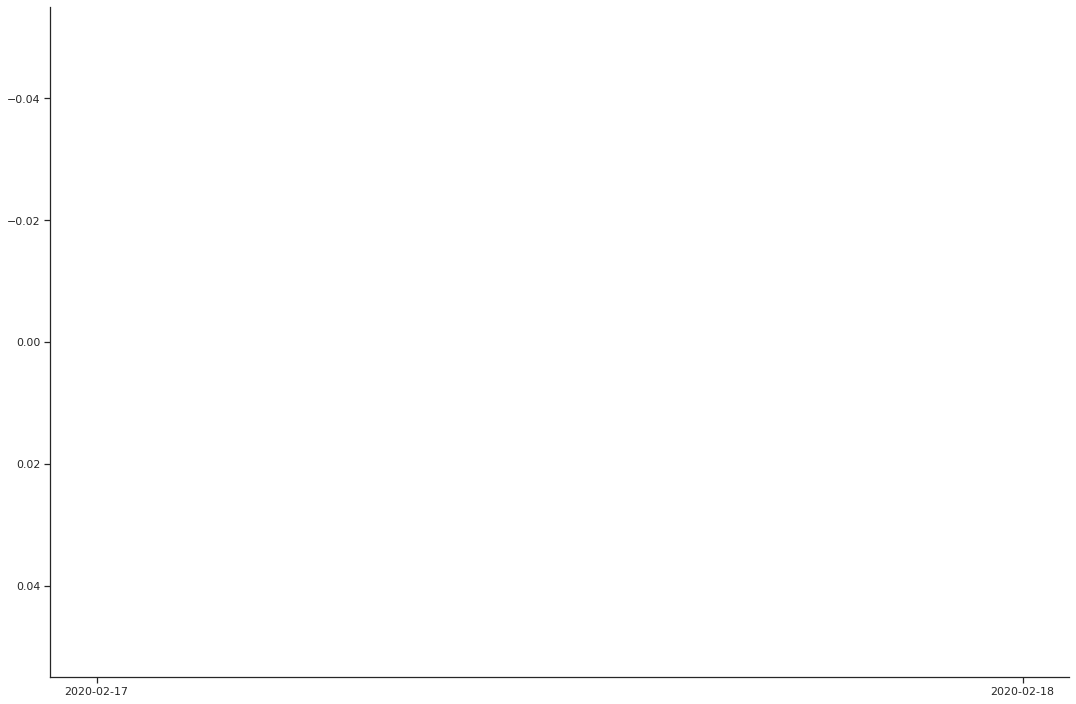

In [37]:
for c in df2.columns:
    if c.__contains__('All') or c.__contains__('time'):
        pass
    else:
        # Plot the lines on two facets
        sns.relplot(
            data=df2,
            x="time", y=c,
            hue="i",
            kind="line",
            height=10, aspect=1.5, 
            facet_kws=dict(sharex=False),
            legend=False
        )

## trying epintervene
https://github.com/andrea-allen/epintervene

In [ ]:
import epintervene